# Self-Driving Car Simulator — Behavioral Cloning (P3)
---

![](images/1_UaIyt_RXPQBgpkZK2HX1Ow.png)

The task is to implement a Deep Neural Network model that predicts the steering angle of a car given images of the road. We are provided with a simulator that can be operated in 2 modes — training and autonomous mode.

In training mode, we drive the car around a track and save the frames (.jpg files) as well as the corresponding steering angle (stored in a .csv file). In fact other parameters values are recorded: throttle, velocity, brake. In autonomous mode, the trained model is used to predict the steering angle and drive the car.

I used the training dataset provided by Udacity, available here. The dataset includes images of the road recorded by 3 cameras mounted on the front of the car, and the csv file with steering angle values for each frame/image.


You can find most of the image effect (image augmentation in `dataset.py` file). The trained model was tested on on track1. Following  animations show the performance of my final model.



In [103]:
# load libraries and set plot parameters
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline

import errno
import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc
from scipy.ndimage import rotate
from scipy.stats import bernoulli

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

In [104]:
class Dataset(object):

    DRIVING_LOG_FILE = '/Users/gangadharkadam/Downloads/data/driving_log.csv'
    IMG_PATH = '/Users/gangadharkadam/Downloads/data/'
    STEERING_COEFFICIENT = 0.229

    def __init__(self):
        self.X_train = None
        self.X_valid = None
        self.X_test  = None
        self.Y_train = None
        self.Y_valid = None
        self.Y_test  = None

    def next_batch(self, batch_size=64):
        while True:
            X_batch = []
            y_batch = []
            images = self.get_next_image_files(batch_size)

            for img_file, angle in images:
                raw_image = plt.imread(self.IMG_PATH + img_file)
                raw_angle = angle
                new_image, new_angle = self.generate_new_image(raw_image, raw_angle)
                X_batch.append(new_image)
                y_batch.append(new_angle)

            assert len(X_batch) == batch_size, 'len(X_batch) == batch_size should be True'

            yield np.array(X_batch), np.array(y_batch)

    def get_next_image_files(self, batch_size=64):
        data        = pd.read_csv(self.DRIVING_LOG_FILE)
        num_of_img  = len(data)
        rnd_indices = np.random.randint(0, num_of_img, batch_size)

        image_files_and_angles = []

        for index in rnd_indices:

            rnd_image = np.random.randint(0, 3)

            if rnd_image == 0:
                img = data.iloc[index]['left'].strip()
                angle = data.iloc[index]['steering'] + self.STEERING_COEFFICIENT
                image_files_and_angles.append((img, angle))

            elif rnd_image == 1:
                img = data.iloc[index]['center'].strip()
                angle = data.iloc[index]['steering']
                image_files_and_angles.append((img, angle))
            else:
                img = data.iloc[index]['right'].strip()
                angle = data.iloc[index]['steering'] - self.STEERING_COEFFICIENT
                image_files_and_angles.append((img, angle))

        return image_files_and_angles

    def generate_new_image(self, image, steering_angle, top_crop_percent=0.35, bottom_crop_percent=0.1,
                           resize_dim=(64, 64), do_shear_prob=0.9):

        head = bernoulli.rvs(do_shear_prob)

        if head == 1:
            image, steering_angle = self.random_shear(image, steering_angle)

        image = self.crop(image, top_crop_percent, bottom_crop_percent)

        image, steering_angle = self.flip(image, steering_angle)

        image = self.random_gamma(image)

        image = self.resize(image, resize_dim)

        return image, steering_angle

    def random_shear(self, image, steering_angle, shear_range=200):
        rows, cols, ch = image.shape
        dx = np.random.randint(-shear_range, shear_range + 1)
        random_point = [cols / 2 + dx, rows / 2]
        pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
        pts2 = np.float32([[0, rows], [cols, rows], random_point])
        dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
        M = cv2.getAffineTransform(pts1, pts2)
        image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
        steering_angle += dsteering

        return image, steering_angle

    def crop(self, image, top_percent, bottom_percent):

        top = int(np.ceil(image.shape[0] * top_percent))
        bottom = image.shape[0] - int(np.ceil(image.shape[0] * bottom_percent))

        return image[top:bottom, :]
    
    def random_crop(image,steering=0.0,tx_lower=-20,tx_upper=20,ty_lower=-2,ty_upper=2,rand=True):
        # we will randomly crop subsections of the image and use them as our data set.
        # also the input to the network will need to be cropped, but of course not randomly and centered.
        shape = image.shape
        col_start,col_end =abs(tx_lower),shape[1]-tx_upper
        horizon=60;
        bonnet=136
        if rand:
            tx= np.random.randint(tx_lower,tx_upper+1)
            ty= np.random.randint(ty_lower,ty_upper+1)
        else:
            tx,ty=0,0

        #    print('tx = ',tx,'ty = ',ty)
        random_crop = image[horizon+ty:bonnet+ty,col_start+tx:col_end+tx,:]
        image = cv2.resize(random_crop,(64,64),cv2.INTER_AREA)
        # the steering variable needs to be updated to counteract the shift 
        if tx_lower != tx_upper:
            dsteering = -tx/(tx_upper-tx_lower)/3.0
        else:
            dsteering = 0
        steering += dsteering

        return image,steering


    def flip(self, image, steering_angle, flipping_prob=0.5):
        head = bernoulli.rvs(flipping_prob)
        if head:
            return np.fliplr(image), -1 * steering_angle
        else:
            return image, steering_angle
        
    def random_flip(image,steering):
        coin=np.random.randint(0,2)
        if coin==0:
            image,steering=cv2.flip(image,1),-steering
        return image,steering


    def random_gamma(self, image):
        gamma = np.random.uniform(0.4, 1.5)
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255
                          for i in np.arange(0, 256)]).astype("uint8")

        # apply gamma correction using the lookup table
        return cv2.LUT(image, table)

    def resize(self, image, new_dim):
        return scipy.misc.imresize(image, new_dim)  

# Data Exploration
The dataset is made of a total of 24,108 color images (for left/center/right camera) of size (160 x 320) px

In [105]:
import csv
import glob
# open csv file
with open(DRIVING_LOG_FILE, 'r') as csvfile:
    file_reader = csv.reader(csvfile, delimiter=',')
    log = []
    for row in file_reader:
        log.append(row)

log = np.array( log )
log = log[1:,:] #remove the header

#account for left/right/center
print('Dataset: \n {} images | Number of steering data: {}'.format(len(log) * 3, len(log)) ) 

# Sanity check: list all image files in data/IMG
ls_imgs = glob.glob(IMG_PATH + 'IMG/*.jpg')
assert len(ls_imgs) == len(log)*3, 'Actual number of *jpg images does not match with the csv log file'

Dataset: 
 24108 images | Number of steering data: 8036


## Image Visualization
The images are RGB format.

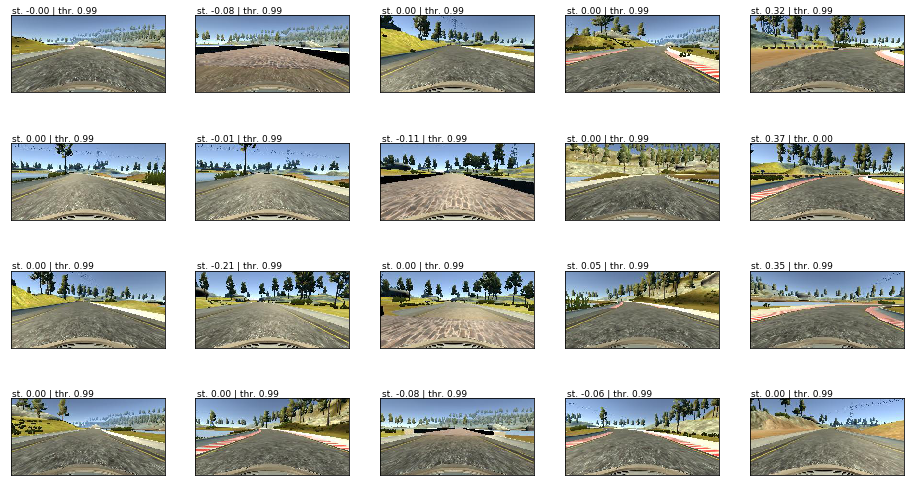

In [121]:
n_imgs = 20
steering_col = 3
throttle_col = 4
ls_imgs = np.random.choice(np.arange(len(log)), size = n_imgs, replace=False)

_, ax = plt.subplots( 4, 5, figsize=(16, 9))
col, row = 0, 0
print(  )
for i in ls_imgs: 
    img = cv2.imread(IMG_PATH+ log[i, 0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[row, col].imshow(img)
    sub_title = 'st. {:.2f} | thr. {:.2f}'.format(float(log[i, steering_col]), float(log[i, throttle_col]) )
    ax[row, col].text(3, -5, sub_title, fontsize=9)
    ax[row, col].get_xaxis().set_ticks([])
    ax[row, col].get_yaxis().set_ticks([])

    if col == 4:
        row, col = row+1, 0
    else:
        col += 1

plt.show()


Below is a typical profile of the steering angle for successive frames :

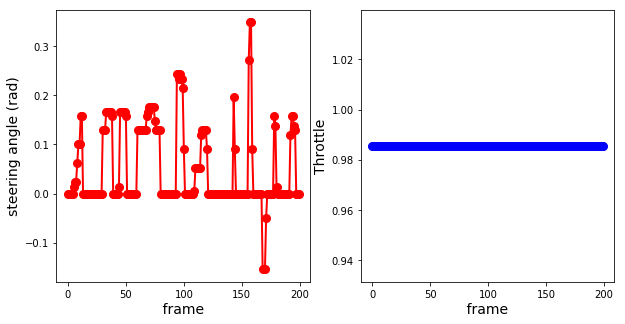

In [122]:

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(np.arange(200), log[200:400, steering_col].astype(float), 'r-o')
ax[0].set_xlabel(' frame ', fontsize=14)
ax[0].set_ylabel('steering angle (rad)', fontsize=14)

ax[1].plot(np.arange(200), log[200:400, throttle_col].astype(float), 'b-o')
ax[1].set_xlabel(' frame ', fontsize=14)
ax[1].set_ylabel('Throttle', fontsize=14)

plt.show()

Number of unique angles value (10^-2 precision): 124


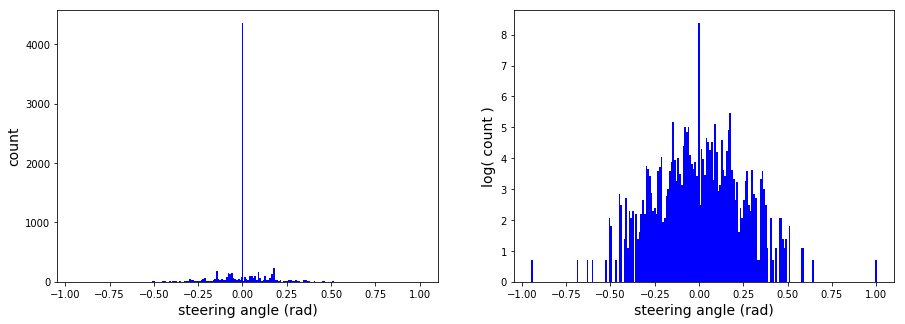

Count of positive angles: 1900 | Negative angles: 1775
Number of unique throttle opening value: 95


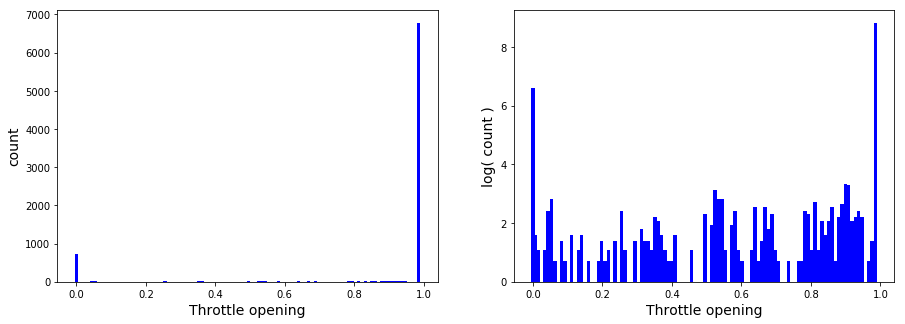

In [123]:
# Set angle value precision to 10^-2
precision = 0.0001
steering_angle = log[:, 3].astype(float) * 1/precision #convert steering to degrees
steering_angle = steering_angle.astype(int) * precision

unique_st_angles = np.unique(steering_angle)
# get unique values
print('Number of unique angles value (10^-2 precision): {}'.format( len(unique_st_angles)) )

# Histogram of steering angle values
hist = []
for i in unique_st_angles :
    count = np.sum( steering_angle == i )
    hist.append([i, count])

hist = np.array(hist)
#plot histogram
_, ax = plt.subplots( 1, 2, figsize=(15, 5) )
ax[0].bar(hist[:,0], hist[:,1], width=0.01, color='b')
ax[0].set_xlabel('steering angle (rad)', fontsize=14)
ax[0].set_ylabel('count', fontsize=14)


ax[1].bar(hist[:,0], np.log( hist[:,1] ), width=0.01, color='b')
plt.xlabel('steering angle (rad)', fontsize=14)
plt.ylabel('log( count )', fontsize=14)

plt.show()

cnt_neg = np.sum(steering_angle < 0)
cnt_pos = np.sum(steering_angle > 0)
print('Count of positive angles: {} | Negative angles: {}'.format(cnt_pos, cnt_neg))

throttle = log[:, 4].astype(float)

unique_throttle = np.unique(throttle)
# get unique values
print('Number of unique throttle opening value: {}'.format( len(unique_throttle)) )

# Histogram of steering angle values
hist = []
for i in unique_throttle :
    count = np.sum( throttle == i )
    hist.append([i, count])

hist = np.array(hist)
#plot histogram
_, ax = plt.subplots( 1, 2, figsize=(15, 5) )
ax[0].bar(hist[:,0], hist[:,1], width=0.01, color='b')
ax[0].set_xlabel('Throttle opening', fontsize=14)
ax[0].set_ylabel('count', fontsize=14)


ax[1].bar(hist[:,0], np.log( hist[:,1] ), width=0.01, color='b')
plt.xlabel('Throttle opening', fontsize=14)
plt.ylabel('log( count )', fontsize=14)

plt.show()

Steering angle s=0 have the highest frequency: more than 20 times larger than the frequency of other angle values. Also, there are more positive (1900 counts) than negative angle values (1775 counts).

## driving_log.csv data

In [127]:
cols = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle', 'Break', 'Speed']
data = pd.read_csv(DRIVING_LOG_FILE, names=cols, header=1)

display(data.head())


,Center Image,Left Image,Right Image,Steering Angle,Throttle,Break,Speed
0,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
1,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
2,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
3,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
4,IMG/center_2016_12_01_13_31_13_279.jpg,IMG/left_2016_12_01_13_31_13_279.jpg,IMG/right_2016_12_01_13_31_13_279.jpg,0.0,0.0,0.0,1.403993


As shown above, the data file contains seven columns: URLs for the captured center, left, and right images; the steering angle; the throttle rate; braking; and speed. Each row captures a snapshot of what was happening in the simulator.

In [128]:
display(data.describe())

,Steering Angle,Throttle,Break,Speed
count,8035.000000,8035.000000,8035.000000,8035.000000
mean,0.004070,0.869768,0.001970,28.170589
std,0.128848,0.301188,0.036567,6.149343
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183100
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


The summary statistics above show some interesting information about the data.
Steering angle: While the steering angle varied between -1 and 1, it was almost always at 0. The mean is slightly to the right, which suggests additional recovery training was done to learn how to recover from the mostly left turning track.
The throttle was almost always fully engaged, only occassionally being released to allow the vehicle to slow down.
The break was only applied very lightly while driving.
The car was driven almost exclusively at its full speed of 30 mph.
It will be interesting to see how successfully the model will be when trained with this high velocity driving and whether it will generalize to slower driving speeds.

# Data Preprocessing Pipeline

- Apply random shear operation. However, we select images with 0.9 probability for the random shearing process. 

- To help the system avoid learning other part of the image but only the track, user crops out the sky and car deck parts in the image. Original image size (160x320), after cropping 60px on top and 20px on the bottom, new image size is (80x320).

- The next stage of the data processing pipeline is called random flip stage. In this stage we randomly (with 0.5 probability) flip images. The idea behind this operation is left turning bends are more prevalent than right bends in the training track.

- To help running a smaller training model, images are scaled to (64x64) size from cropped size (80x320).



## Random Shearing

I used images from all three cameras. Images taken from the side cameras are akin to parallel translations of the car. To account for being off-center I adjusted the steering angle for images taken from the side cameras as follows: ignoring perspective distortions one could reason that if the side cameras are about 1.2 meters off-center and the car is supposed to get back to the middle of the road within the next 20 meters the correction to the steering should be about 1.2/20 radians (using tan(𝛼)~𝛼). This turned out to be a quite powerful means to make the car avoid the sides of the road.

In the next stage each image got sheared horizontally. The pixels at the bottom of the image were held fixed while the top row was moved randomly to the left or right. The steering angle was changed proportionally to the shearing angle. This had the effect of making curvy road pieces appear just as often in the training set as straight parts.

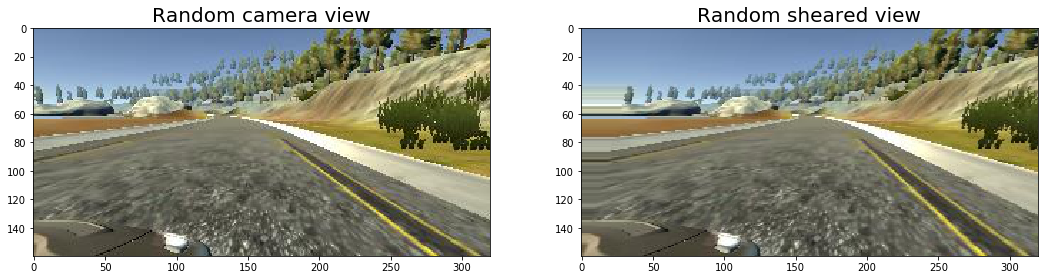

In [129]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline



img=plt.imread(IMG_PATH + 'IMG/right_2016_12_01_13_41_21_968.jpg')
steering=-0.1452064
#plt.imshow(img)

img_shear,steering_shear=random_shear(img,steering,100)
plt.figure()
#plt.imshow(img_shear)
#plt.imsave('images/img_shear.jpg',img_shear)
steering,steering_shear


fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img)
plt.title('Random camera view')


ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img_shear)
plt.title('Random sheared view')

plt.savefig('images/random_sheared', dpi=300)

## Random Cropping
So far all transformations had been performed on the full 320x160 pixel images coming from the cameras. In the next stage I chose a window of 280x76 pixels that eliminated the bonnet from the bottom of the image and cropped off the part above the horizon in flat terrain at the top. For each image the location of this window was displaced randomly from the center along the x-and y-axes by up to ±20 and ±10 pixels, respectively. The steering angle was changed proportionally to the lateral displacement of the crop. Thereby, also images of the car being in hilly terrain were simulated and a greater variety of images than available from the side cameras could be obtained. The result was then resized to 64x64 pixels.

Text(0.5,1,'Random crop: corrected steering angle: 0.125°')

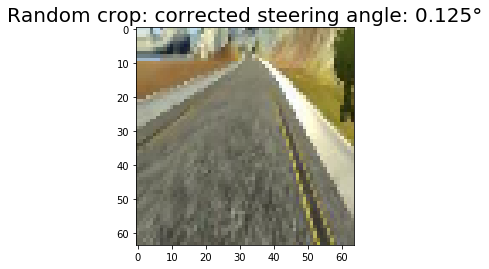

In [132]:
img_crop,steering_crop=random_crop(img_shear,steering_shear,tx_lower=-20,tx_upper=20,ty_lower=-10,ty_upper=10,rand=True)
plt.imshow(img_crop)
#plt.imsave('img_crop.jpg',img_crop)
steering_shear, steering_crop
plt.title('Random crop: corrected steering angle: 0.125°')

## Random Flipping
Finally, each image was randomly flipped (horizontally) with equal probability in order to make left and right turns appear as frequently. Also brightness was randomly adjusted.

-0.005061214147894032

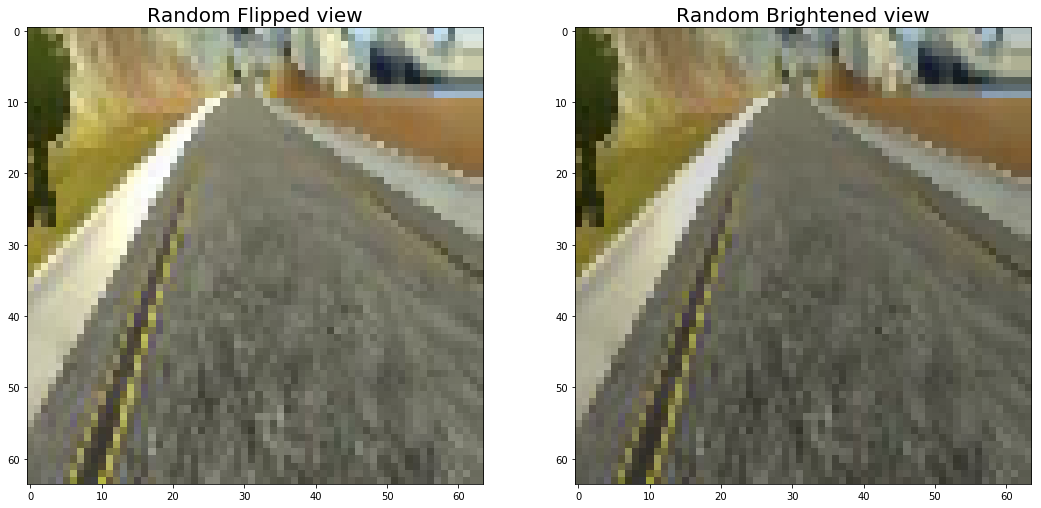

In [133]:
img_flip,steering_flip = random_flip(img_crop,steering_crop)
plt.figure()
#plt.imshow(img_flip)
#plt.imsave('img_flip.jpg',img_flip)


img_bright=random_brightness(img_flip)
plt.figure()
#plt.imshow(img_bright)
#plt.imsave('img_bright.jpg',img_bright)



fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img_flip)
plt.title('Random Flipped view')
steering_crop,steering_flip

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img_bright)
plt.title('Random Brightened view')
steering_flip

The dataset consists of 24108 images (8036 images per camera angle). The training track contains a lot of shallow turns and straight road segments. Hence, the majority of the recorded steering angles are zeros. Therefore, preprocessing images and respective steering angles are necessary in order to generalize the training model for unseen tracks such as our validation track.

# Model architecture and training

My convolutional neural network architecture was inspired by NVIDIA's End to End Learning for Self-Driving Cars paper. The main difference between our model and the NVIDIA mode is than we did use MaxPooling layers just after each  Convolutional Layer in order to cut down training time. 

- 1st layer: normalize input image to -0.5 to 0.5 range.

- For optimizer, Adam optimizer is used. I started with 0.001 training rate but 0.0001 seems to produce a smoother ride. Therefore, I kept 0.0001 learning rate.

### Training

Even after cropping and resizing training images (with all augmented images), training dataset was very large and it could not fit into the main memory. Hence, we used `fit_generator` API of the Keras library for training our model.

I created two generators namely:

* `train_batch = Dataset().next_batch()`
* `validation_batch = Dataset().next_batch()` 

Batch size of both `train_batch` and `validation_batch` was 64. We used 20032 images per training epoch. It is to be noted that these images are generated on the fly using the document processing pipeline described above. In addition to that, we used 6400 images (also generated on the fly) for validation. We used `Adam` optimizer with `1e-4` learning rate. Finally, when it comes to the number of training epochs we tried several possibilities such as `5`, `8`, `1`0, `2`5 and `50`. However, `6` works well on both training and validation tracks. 


In [113]:
from __future__ import print_function
import random

import numpy as np
from sklearn.cross_validation import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Lambda
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K
import errno
import json
import os

class BehavioralCloningNet(object):

    FILE_PATH = 'model.h5'

    def __init__(self):
        self.model = None
        self.number_of_epochs = 6
        self.number_of_samples_per_epoch = 20032
        self.number_of_validation_samples = 6400
        self.learning_rate = 1e-4
        self.activation_relu = 'relu'
        self.dataset = Dataset()


    # Our model is based on NVIDIA's "End to End Learning for Self-Driving Cars" paper
    # Source:  https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
    def build_model(self):

        model = Sequential()

        # Normalize the data
        model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(64, 64, 3)))

        # starts with five convolutional and maxpooling layers
        model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2, 2)))
        model.add(Activation(self.activation_relu))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

        model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2, 2)))
        model.add(Activation(self.activation_relu))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

        model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2, 2)))
        model.add(Activation(self.activation_relu))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

        model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
        model.add(Activation(self.activation_relu))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

        model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
        model.add(Activation(self.activation_relu))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

        model.add(Flatten())

        model.add(Dense(1164))
        model.add(Activation(self.activation_relu))

        model.add(Dense(100))
        model.add(Activation(self.activation_relu))

        model.add(Dense(50))
        model.add(Activation(self.activation_relu))

        model.add(Dense(10))
        model.add(Activation(self.activation_relu))

        model.add(Dense(1))

        model.summary()

        self.model = model

    def compile(self):

        self.model.compile(optimizer=Adam(self.learning_rate), loss="mse")

        # let's train the model using SGD + momentum (how original :P ).
        # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        # self.model.compile(loss='categorical_crossentropy',
                           # optimizer=sgd,
                           # metrics=['accuracy'])

    def augmentation(self, dataset):

        # this will do preprocessing and realtime data augmentation
        datagen = ImageDataGenerator(
                featurewise_center=False,             # set input mean to 0 over the dataset
                samplewise_center=False,              # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,   # divide each input by its std
                zca_whitening=False,                  # apply ZCA whitening
                horizontal_flip=True,                 # randomly flip images
                vertical_flip=False)                  # randomly flip images

        # compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied)
        datagen.fit(dataset.X_train)
        self.datagen = datagen


    def train(self):
        print('Start training.')

        train_batch      = self.dataset.next_batch()
        validation_batch = self.dataset.next_batch()

        history = self.model.fit_generator(
                train_batch,
                samples_per_epoch=self.number_of_samples_per_epoch,
                nb_epoch=self.number_of_epochs,
                validation_data=validation_batch,
                nb_val_samples=self.number_of_validation_samples,
                verbose=1
            )

        self.history = history

    def save(self):
        self.model.save(self.FILE_PATH)
        print('Model Saved.')

    def load(self):
        print('Model Loaded.')
        self.model = load_model(self.FILE_PATH)

    def predict(self, image):
        image = image.astype('float32')
        result = self.model.predict_proba(image)
        print(result)
        result = self.model.predict_classes(image)

        return result[0]

    def evaluate(self, dataset):
        score = self.model.evaluate(dataset.X_test, dataset.Y_test, verbose=0)
        print("%s: %.2f%%" % (self.model.metrics_names[1], score[1] * 100))



In [114]:
model = BehavioralCloningNet()
model.build_model()
model.compile()
model.train()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_5 (Lambda)                (None, 64, 64, 3)     0           lambda_input_5[0][0]             
____________________________________________________________________________________________________
convolution2d_21 (Convolution2D) (None, 32, 32, 24)    1824        lambda_5[0][0]                   
____________________________________________________________________________________________________
activation_37 (Activation)       (None, 32, 32, 24)    0           convolution2d_21[0][0]           
____________________________________________________________________________________________________
maxpooling2d_21 (MaxPooling2D)   (None, 31, 31, 24)    0           activation_37[0][0]              
___________________________________________________________________________________________

/Users/gangadharkadam/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:147: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


20032/20032 [==============================] - 390s - loss: 0.0666 - val_loss: 0.0304
Epoch 2/6
20032/20032 [==============================] - 409s - loss: 0.0290 - val_loss: 0.0249
Epoch 3/6
20032/20032 [==============================] - 405s - loss: 0.0246 - val_loss: 0.0225
Epoch 4/6
20032/20032 [==============================] - 374s - loss: 0.0216 - val_loss: 0.0208
Epoch 5/6
20032/20032 [==============================] - 408s - loss: 0.0193 - val_loss: 0.0201
Epoch 6/6
20032/20032 [==============================] - 410s - loss: 0.0183 - val_loss: 0.0178


In [116]:
model.save()

Model Saved.
